In [ ]:
!pip install fastai
!pip install gdown
!pip install torchvision
!pip install tldextract
!pip install torch
!pip install torchvision
# !pip install Pillow==6.2.0
!pip uninstall annoy
!pip install annoy==1.17.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 27.8 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=397030 sha256=006fa863e07108c012af73a803605a5d29812be807de35dd16ce90ae373a856a
  Stored in directory: /root/.ca

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
from zipfile import ZipFile
import urllib.request
import os
import requests
import subprocess
from bs4 import BeautifulSoup
import tldextract
import torch
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image

%matplotlib inline

In [ ]:

train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Wed Nov 30 02:06:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    45W / 400W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                

In [ ]:
fashion_df = pd.read_json("/content/fashion.json",lines=True)
fashion_df.head()

,product,scene,bbox
0,0027e30879ce3d87f82f699f148bff7e,cdab9160072dd1800038227960ff6467,"[0.43409699999999996, 0.859363, 0.560254, 1.0]"
1,0027e30879ce3d87f82f699f148bff7e,14f59334af4539132981b1324a731067,"[0.17526899999999998, 0.5277729999999999, 0.621485, 0.9248989999999999]"
2,0027e30879ce3d87f82f699f148bff7e,e7d32df9f45b691afc580808750f73ca,"[0.588666, 0.6385029999999999, 0.750647, 0.7613679999999999]"
3,0027e30879ce3d87f82f699f148bff7e,c0be585ed21b1a6c6dc9559ebe007ede,"[0.276699, 0.757741, 0.400485, 0.876138]"
4,002a6586b8381b5efd39410657630b44,67ed2a06be8a26dc63d7a04d4e1a135f,"[0.154545, 0.144809, 0.809091, 0.784153]"


In [ ]:
fashion_cat_df = pd.read_json("/content/fashion-cat.json", typ = 'series')
fashion_cat_df.head()

8870b0d384138a81cfdc91f98d1dde9b                     Apparel & Accessories|Shoes
70d392390fa258ba9b5d6b83ea29857e                     Apparel & Accessories|Shoes
2c05db9ff1abbcfc4bfd50dd003aac80            Apparel & Accessories|Clothing|Pants
2b2cc3a8b588b7282be0511568b51ee7    Apparel & Accessories|Clothing|Shirts & Tops
a141ed588bdaeccf1f695889a5aa7085           Apparel & Accessories|Clothing|Shorts
dtype: object

In [ ]:
fashion_cat_df = pd.DataFrame(fashion_cat_df)
fashion_cat_df.reset_index(inplace = True)
col_names = ['product', 'label']
fashion_cat_df.columns = col_names
fashion_cat_df.head()

,product,label
0,8870b0d384138a81cfdc91f98d1dde9b,Apparel & Accessories|Shoes
1,70d392390fa258ba9b5d6b83ea29857e,Apparel & Accessories|Shoes
2,2c05db9ff1abbcfc4bfd50dd003aac80,Apparel & Accessories|Clothing|Pants
3,2b2cc3a8b588b7282be0511568b51ee7,Apparel & Accessories|Clothing|Shirts & Tops
4,a141ed588bdaeccf1f695889a5aa7085,Apparel & Accessories|Clothing|Shorts


In [ ]:
new_fashion_df = pd.merge(fashion_df, fashion_cat_df, on="product")
new_fashion_df.head()

,product,scene,bbox,label
0,0027e30879ce3d87f82f699f148bff7e,cdab9160072dd1800038227960ff6467,"[0.43409699999999996, 0.859363, 0.560254, 1.0]",Apparel & Accessories|Shoes
1,0027e30879ce3d87f82f699f148bff7e,14f59334af4539132981b1324a731067,"[0.17526899999999998, 0.5277729999999999, 0.621485, 0.9248989999999999]",Apparel & Accessories|Shoes
2,0027e30879ce3d87f82f699f148bff7e,e7d32df9f45b691afc580808750f73ca,"[0.588666, 0.6385029999999999, 0.750647, 0.7613679999999999]",Apparel & Accessories|Shoes
3,0027e30879ce3d87f82f699f148bff7e,c0be585ed21b1a6c6dc9559ebe007ede,"[0.276699, 0.757741, 0.400485, 0.876138]",Apparel & Accessories|Shoes
4,0027e30879ce3d87f82f699f148bff7e,fa5292c6c728810f6bfee095a3824dbd,"[0.641984, 0.773521, 0.804771, 0.8605459999999999]",Apparel & Accessories|Shoes


In [ ]:
col_list = new_fashion_df.label.values.tolist()
label_list = []
for lab in col_list:
  new_label = lab.split('|')[-1]
  label_list.append(new_label)

label_df = pd.DataFrame(label_list, columns = ['label'])
# label_df.head()

In [ ]:
new_fashion_df['label'] = label_df
new_fashion_df.head()

,product,scene,bbox,label
0,0027e30879ce3d87f82f699f148bff7e,cdab9160072dd1800038227960ff6467,"[0.43409699999999996, 0.859363, 0.560254, 1.0]",Shoes
1,0027e30879ce3d87f82f699f148bff7e,14f59334af4539132981b1324a731067,"[0.17526899999999998, 0.5277729999999999, 0.621485, 0.9248989999999999]",Shoes
2,0027e30879ce3d87f82f699f148bff7e,e7d32df9f45b691afc580808750f73ca,"[0.588666, 0.6385029999999999, 0.750647, 0.7613679999999999]",Shoes
3,0027e30879ce3d87f82f699f148bff7e,c0be585ed21b1a6c6dc9559ebe007ede,"[0.276699, 0.757741, 0.400485, 0.876138]",Shoes
4,0027e30879ce3d87f82f699f148bff7e,fa5292c6c728810f6bfee095a3824dbd,"[0.641984, 0.773521, 0.804771, 0.8605459999999999]",Shoes


In [ ]:
new_fashion_df[['product','label']].groupby('label').count()

,product
label,
Coats & Jackets,4788
Earrings,1507
"Handbags, Wallets & Cases",6322
Necklaces,1428
Pants,14289
Shirts & Tops,11957
Shoes,22706
Shorts,2752
Skirts,1872


In [ ]:
def convert_to_url(signature):
    prefix = 'http://i.pinimg.com/400x/%s/%s/%s/%s.jpg'
    return prefix % (signature[0:2], signature[2:4], signature[4:6], signature)

In [ ]:
os.mkdir('/content/scene_images')
os.chdir('/content/scene_images')
print(os.getcwd())

/content/scene_images


In [ ]:
scene_image_urls = []
name = 'images'
for i in range(1000):
    scene_image_url = convert_to_url(fashion_df['scene'].iloc[i])
    scene_image_urls.append(scene_image_url)

In [ ]:
for img in scene_image_urls:
    # We can split the file based upon / and extract the last split within the python list below:
    file_name = img.split('/')[-1]
    # print(f"This is the file name: {file_name}")
    # Now let's send a request to the image URL:

    r = requests.get(img, stream=True)
    # We can check that the status code is 200 before doing anything else:
    if r.status_code == 200:
        # This command below will allow us to write the data to a file as binary:
        with open(file_name, 'wb') as f:
            for chunk in r:
                f.write(chunk)
    else:
        # We will write all of the images back to the broken_images list:
        scene_image_urls.append(img)

# scene_image_urls

In [ ]:
cd /content

/content


In [ ]:
!pip uninstall Pillow

Found existing installation: Pillow 7.1.2
Uninstalling Pillow-7.1.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/PIL/*
    /usr/local/lib/python3.7/dist-packages/Pillow-7.1.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libfreetype-69f25d5e.so.6.17.1
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libjpeg-ba7bf5af.so.9.4.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblcms2-a6801db4.so.2.0.8
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblzma-99449165.so.5.2.5
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libopenjp2-b3d7668a.so.2.3.1
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libpng16-bedcb7ea.so.16.37.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libtiff-41910f6d.so.5.5.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libwebp-122bd20b.so.7.1.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libwebpdemux-2db559e5.so.2.0.6
    /usr/local/lib/python3.7/dist-packages/Pillow.li

In [ ]:
!pip install Pillow==9.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.0 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [ ]:
!pip install torch

import torch
from torchvision import models, transforms
import torch.nn as nn
from annoy import AnnoyIndex

scene_image_folder = '/content/scene_images'
scene_images = os.listdir(scene_image_folder)


weights = models.ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights=weights)

model.fc = nn.Identity()
# print(model)

model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()                              
    ])

annoy_index = AnnoyIndex(2048, 'angular')

for i in range(len(scene_images)):
  image = Image.open(os.path.join(scene_image_folder, scene_images[i]))
  input_tensor = transform(image).unsqueeze(0)

  if input_tensor.size()[1] == 3:
    output_tensor = model(input_tensor)
    annoy_index.add_item(i, output_tensor[0])

    if i % 100 == 0:
      print(f"Processed {i} images")
    # print(f'{image} predicted as {weights.meta["categories"][torch.argmax(output_tensor)]}')

annoy_index.build(n_trees= 20,n_jobs = -1)
annoy_index.save('scene_index.ann')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Processed 0 images
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images


True

## **Find similar images using Annoy**

In [ ]:
annoy_index.load('scene_index.ann')

True

In [ ]:
os.mkdir('/content/annoy_scene_images')
os.chdir('/content/annoy_scene_images')
print(os.getcwd())

/content/annoy_scene_images


In [ ]:
# os.mkdir('/content/annoy_scene2_images')
os.chdir('/content/annoy_scene2_images')
print(os.getcwd())

/content/annoy_scene2_images


In [ ]:
from PIL import ImageDraw,Image

scene_image_grid = Image.new('RGB', (300,300))

for i in range(len(scene_images)):
  image = Image.open(os.path.join(scene_image_folder, scene_images[i]))
  input_tensor = transform(image).unsqueeze(0)

  if input_tensor.size()[1] == 3:
    output_tensor = model(input_tensor)
    nns = annoy_index.get_nns_by_vector(output_tensor[0], 8)
    image = image.resize((100, 100))
    image_draw = ImageDraw.Draw(image)
    image_draw.rectangle([(0,0), (99,99)], outline = 'red', width = 8)
    scene_image_grid.paste(image, ((0,0)))

    for j in range(8):
      search_image = Image.open(os.path.join(scene_image_folder, scene_images[nns[j]]))
      search_image = search_image.resize((100, 100))
      scene_image_grid.paste(search_image, (100 * ((j+1)%3), 100 * ((j+1)//3)))

    scene_image_grid.save(f'img_{i}.png')

In [ ]:
annoy_scene_folder2 = '/content/annoy_scene2_images'
annoy_scene_path2 = os.listdir(annoy_scene_folder2)

In [ ]:
annoy_scene_path2

['img_5.png',
 'img_24.png',
 'img_22.png',
 'img_16.png',
 'img_7.png',
 'img_0.png',
 'img_4.png',
 'img_19.png',
 'img_23.png',
 'img_8.png',
 'img_20.png',
 'img_13.png',
 'img_17.png',
 'img_11.png',
 'img_12.png',
 'img_18.png',
 'img_10.png',
 'img_25.png',
 'img_21.png',
 'img_3.png',
 'img_6.png',
 'img_9.png',
 'img_14.png',
 'img_1.png',
 'img_2.png',
 'img_15.png']




Example0





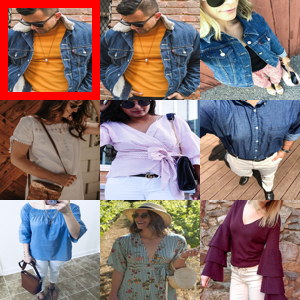




Example1





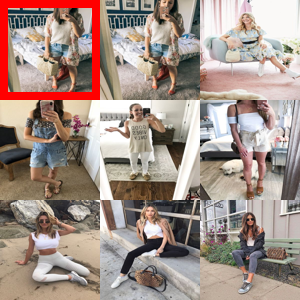




Example2





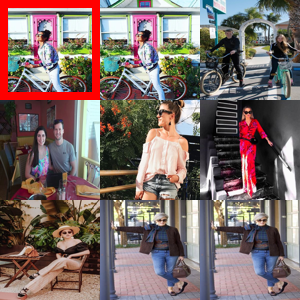




Example3





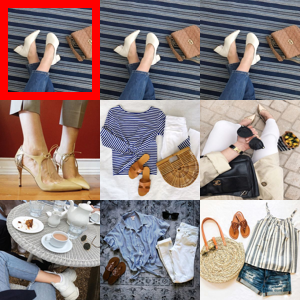




Example4





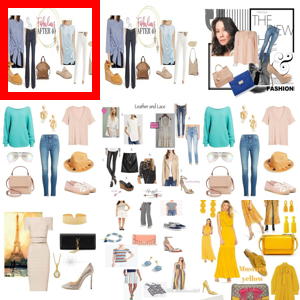




Example5





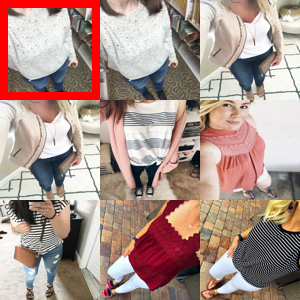




Example6





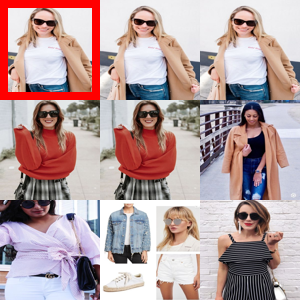




Example7





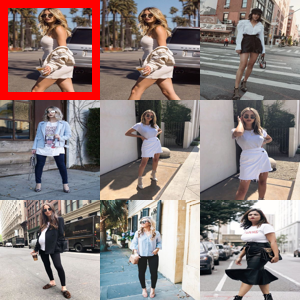




Example8





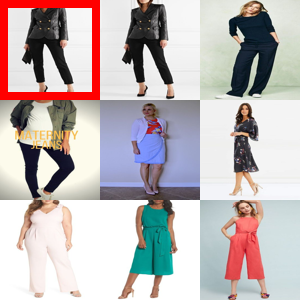




Example9





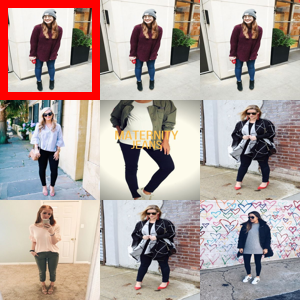

In [ ]:
from IPython.display import Image, display
for i in range(10):
  img = os.path.join(annoy_scene_folder2, annoy_scene_path2[i])
  print("\n\n")
  print(f"Example{i}")
  print("\n\n")
  display(Image(img))

In [ ]:
import PIL

In [ ]:
PIL.__version__

'9.2.0'

In [ ]:
!pip install Pillow==9.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import ImageDraw,Image
full_scenes = []
scene_image_grid = Image.new('RGB', (1000,1000))

for i in range(10):
  scene_names = []
  image = Image.open(os.path.join(scene_image_folder, scene_images[i]))
  scene_names.append(scene_images[i])
  input_tensor = transform(image).unsqueeze(0)
  output_tensor = model(input_tensor)
  if input_tensor.size()[1] == 3:
    output_tensor = model(input_tensor)
    nns = annoy_index.get_nns_by_item(i, 10)

    for j in range(len(nns)):
      scene_names.append(scene_images[nns[j]][:-4])
    full_scenes.append(scene_names)

In [ ]:
total_similar = []
for i in range(10):
  for j in range(1,11):
    prod_index = fashion_df[fashion_df['scene']==full_scenes[i][j]].index.values
    product_names = fashion_df['product'].iloc[prod_index].values

    # print(product_names)
  total_similar.append(product_names)

In [ ]:
print(len(total_similar))

10


In [ ]:
# similar_products = []
# for i in range(len(total_similar)):
#   similar_products.append(total_similar[i])

In [ ]:
# similar_products

In [ ]:
os.mkdir('/content/similar_products')
os.chdir('/content/similar_products')
print(os.getcwd())

/content/similar_products


In [ ]:
# for img in product_image_urls:
#     # We can split the file based upon / and extract the last split within the python list below:
#     file_name = img.split('/')[-1]
#     # print(f"This is the file name: {file_name}")
#     # Now let's send a request to the image URL:

#     r = requests.get(img, stream=True)
#     # We can check that the status code is 200 before doing anything else:
#     if r.status_code == 200:
#         # This command below will allow us to write the data to a file as binary:
#         with open(file_name, 'wb') as f:
#             for chunk in r:
#                 f.write(chunk)
#     else:
#         # We will write all of the images back to the broken_images list:
#         product_image_urls.append(img)

# # product_image_urls:

In [ ]:
total_products = []
name = 'images'
for i in range(len(total_similar)):
  product_image_urls = []
  for j in range(len(total_similar[i])):
    product_image_url = convert_to_url(total_similar[i][j])
    product_image_urls.append(product_image_url)
  total_products.append(product_image_urls)

[['http://i.pinimg.com/400x/0f/a5/f2/0fa5f268f84ef0d19508fd0eb8295d33.jpg'], ['http://i.pinimg.com/400x/45/e8/27/45e827f11a61ff7ef7685b8f415f9bc6.jpg', 'http://i.pinimg.com/400x/c0/9c/91/c09c91fb21b14448cf03035840aae257.jpg', 'http://i.pinimg.com/400x/17/8a/f9/178af9c0dbb0e52ab7c61371d82a8422.jpg'], ['http://i.pinimg.com/400x/cf/4c/1b/cf4c1b00451187f9276a516003dd98ce.jpg', 'http://i.pinimg.com/400x/a5/67/69/a567697fc30c0510aad1307939002d25.jpg'], ['http://i.pinimg.com/400x/28/de/f2/28def2dee8f2d71215df5ec4562d2f18.jpg', 'http://i.pinimg.com/400x/88/79/5e/88795ef48115333206ef63c4635093fc.jpg', 'http://i.pinimg.com/400x/8a/10/64/8a1064a7faadc4e164777e0e3ee3330a.jpg', 'http://i.pinimg.com/400x/bf/84/87/bf8487084f6b89985495e6f761f8042e.jpg', 'http://i.pinimg.com/400x/5f/7b/4f/5f7b4fb1f1f56c9d37fc4b4c98f5dc09.jpg', 'http://i.pinimg.com/400x/b0/3a/b0/b03ab045237eda8a78ba6d8de6d3179f.jpg', 'http://i.pinimg.com/400x/f8/2a/d3/f82ad38ace57c27fd3c9f0eb1a866fea.jpg', 'http://i.pinimg.com/400x/8d/b

In [ ]:
print(scene_names)

['02db4aae8eb6a7299926da40586b677c.jpg', '02db4aae8eb6a7299926da40586b677c', 'dea01f4a758bb5fe98dc3833961e1358', '16ff4a8f78cf66da6983c49285fb8e05', '27169dc23e61dc90f28e528e560c6d8f', 'e7ba60cc872730b318b06235a0429756', 'ddd44d465d75a527b8205cc2d4b4461b', '1bba7b415f60fa7dd3628183e912e99b', '06ba25501b2797cd72e1183560a4be11', '18ef7c3d3381b00bcba551e88d0bc60f', '68279b3f4bed035b217877a68034d69d']


Recommendation for ['1baa01b91f9ac4df50921ccd4f59a8b3.jpg']:


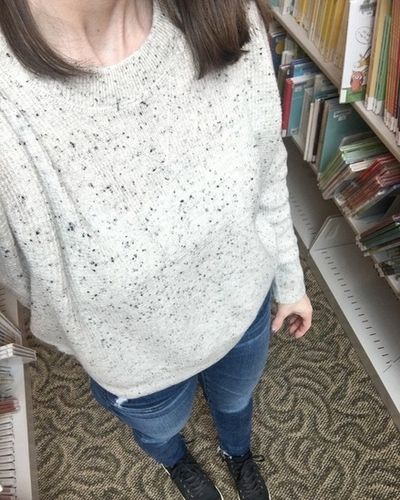

Recommendation:



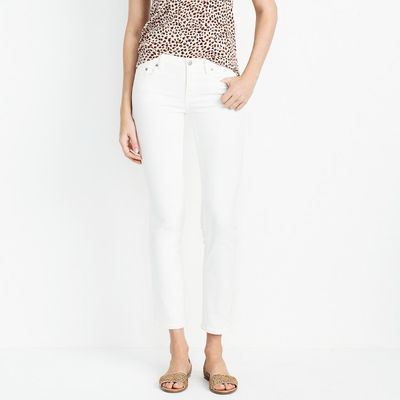



Recommendation for ['266798d5eef7ce74a8944ce055c1a2a3.jpg']:


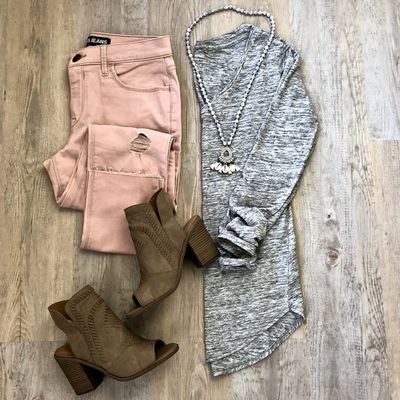

Recommendation:



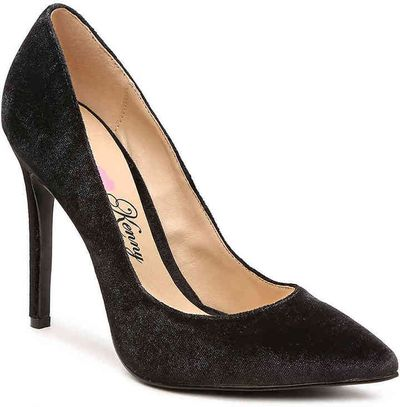



Recommendation:



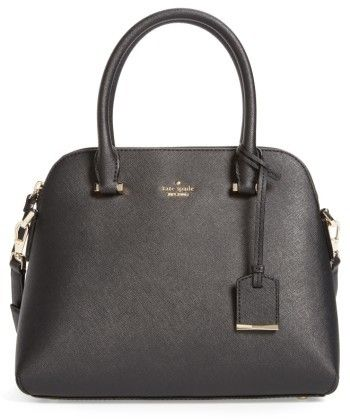



Recommendation:



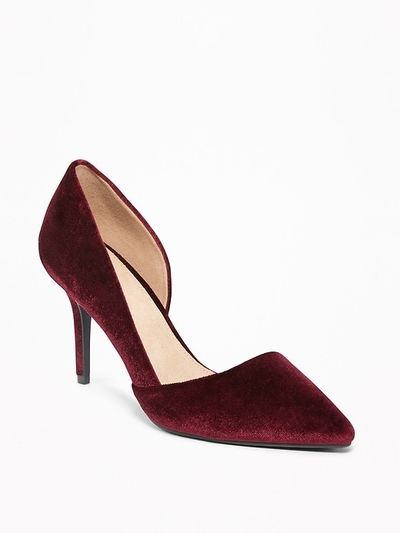



Recommendation for ['ddf1f7e41fcb228c6cf03a6a7018aa9a.jpg']:


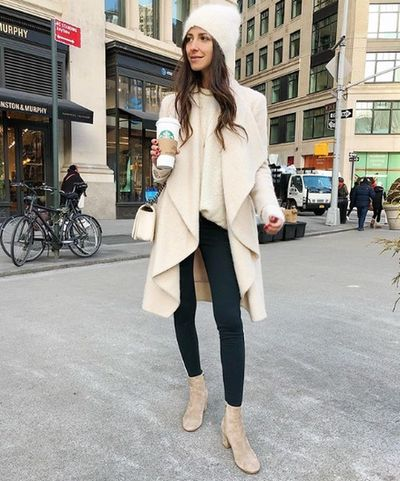

Recommendation:



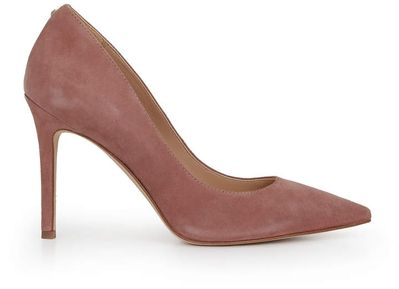



Recommendation:



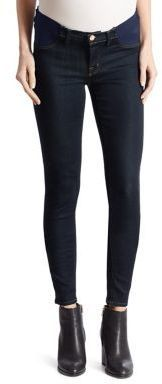



Recommendation for ['57d8f3fb0173543086104a602565616c.jpg']:


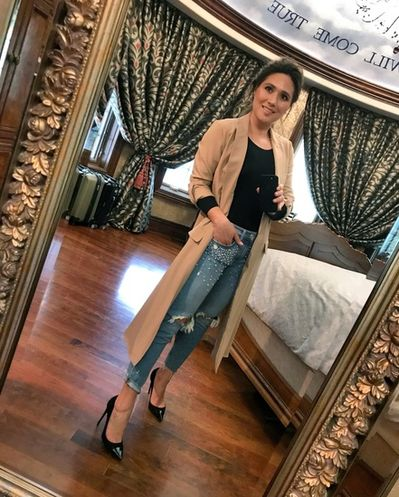

Recommendation:



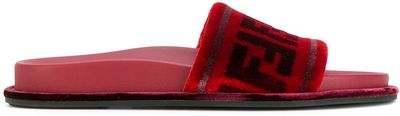



Recommendation:



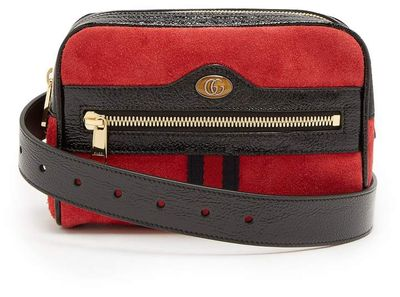



Recommendation:



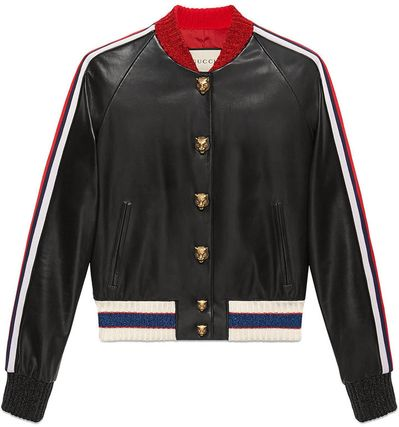



Recommendation:



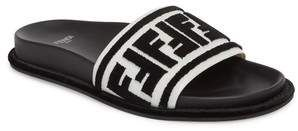



Recommendation:



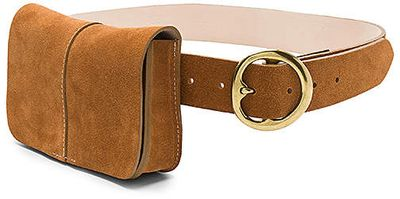



Recommendation:



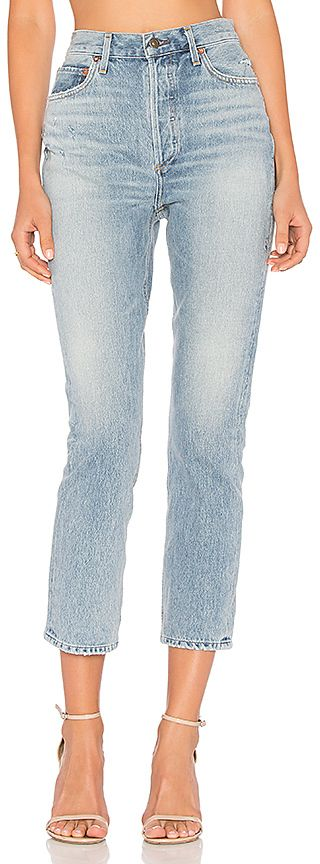



Recommendation:



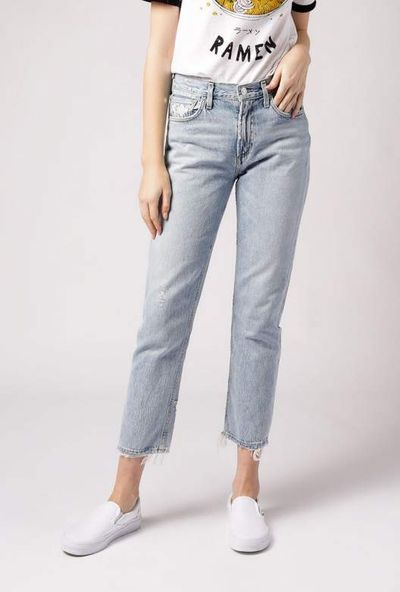



Recommendation:



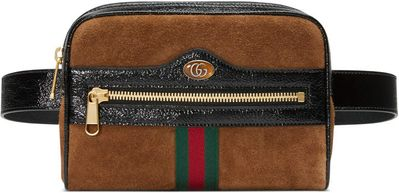



Recommendation:



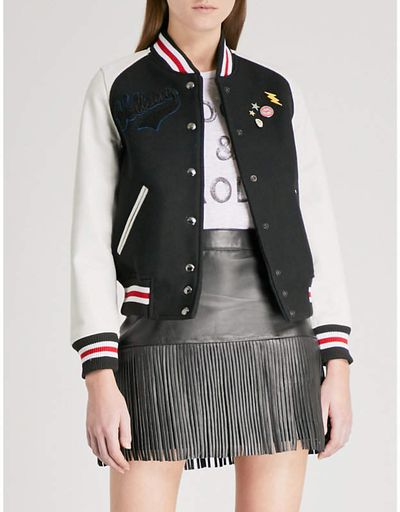



Recommendation:



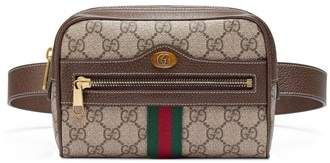



Recommendation:



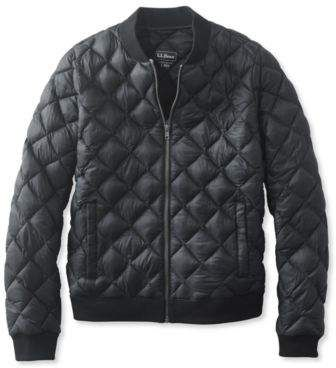



Recommendation:



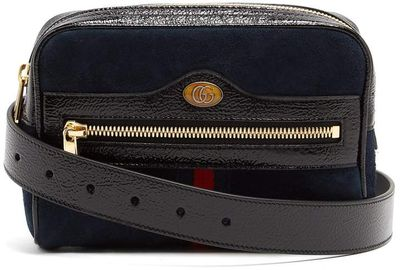



Recommendation:



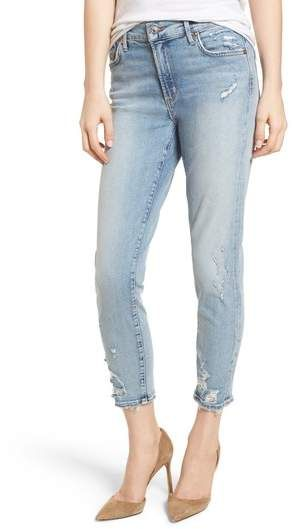



Recommendation:



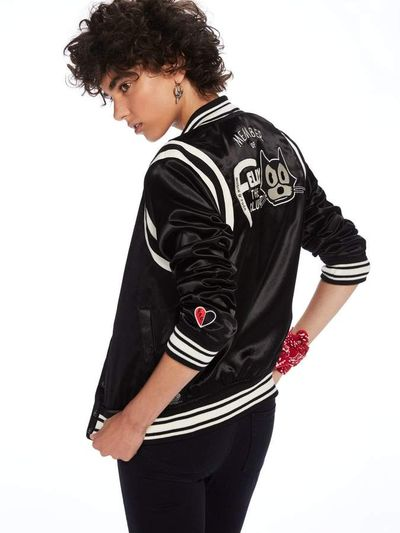



Recommendation:



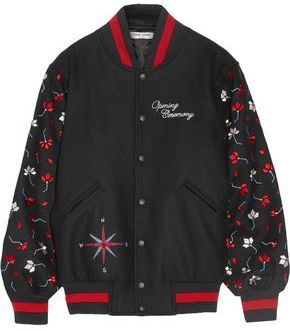



Recommendation:



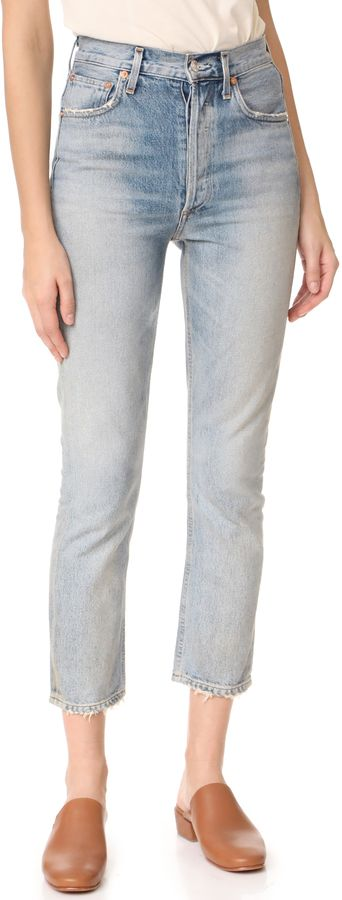



Recommendation for ['cb147520cae99985a58db72f657dd05c.jpg']:


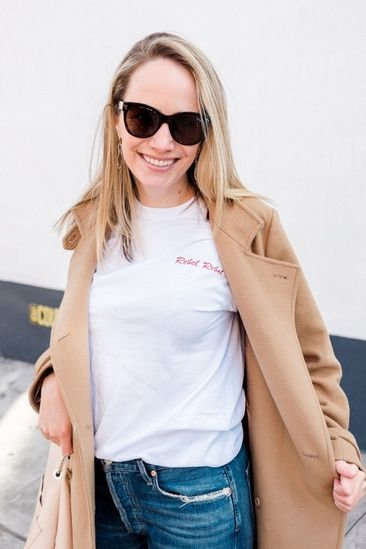

Recommendation:



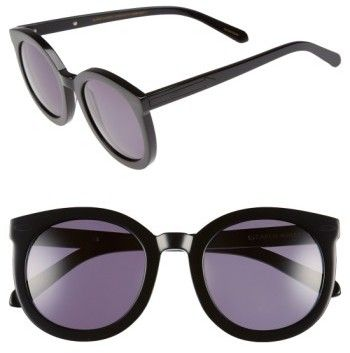



Recommendation:



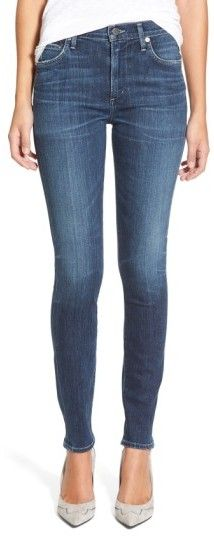



Recommendation:



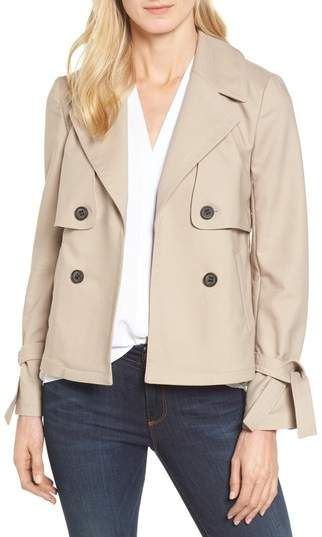



Recommendation for ['269c4ec7352dc0d3d5d0ec511ec7bc7f.jpg']:


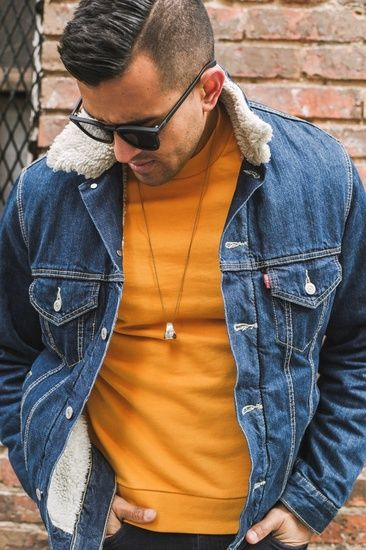

Recommendation:



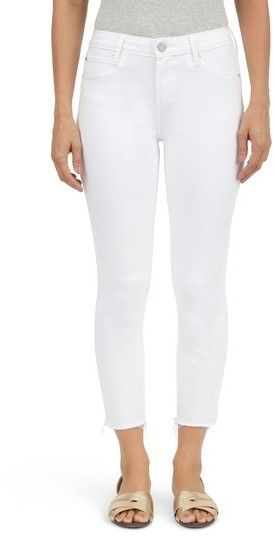



Recommendation:



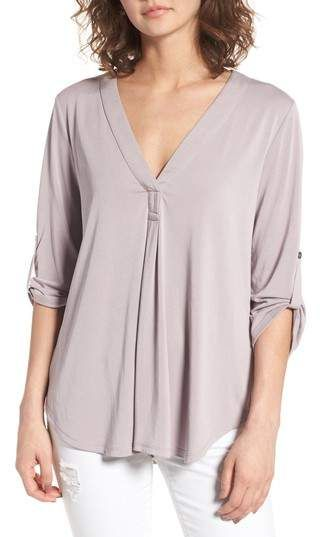



Recommendation:



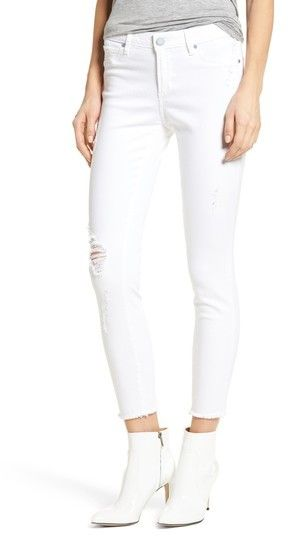



Recommendation for ['85aca86e3970f488ef284ce7e31f4666.jpg']:


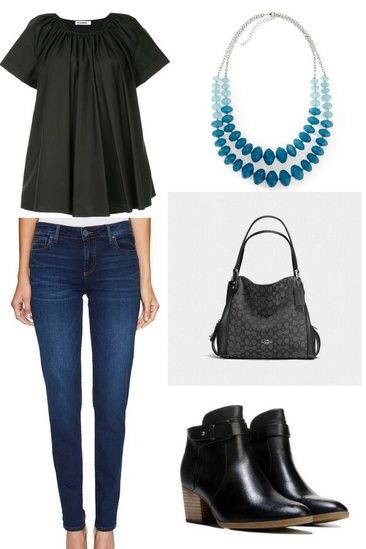

Recommendation:



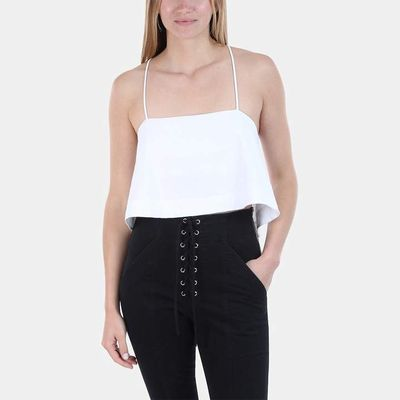



Recommendation:



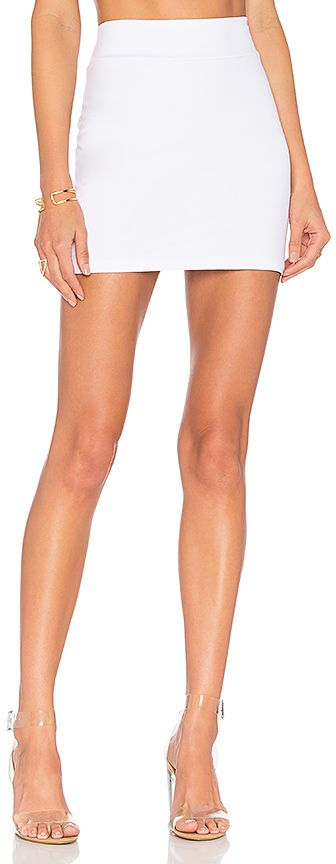



Recommendation:



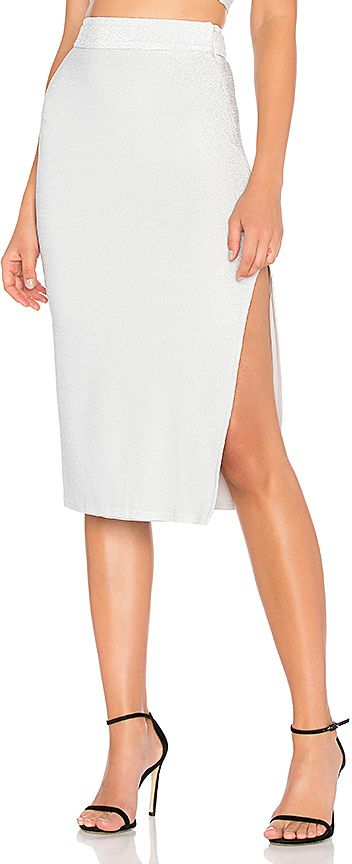



Recommendation:



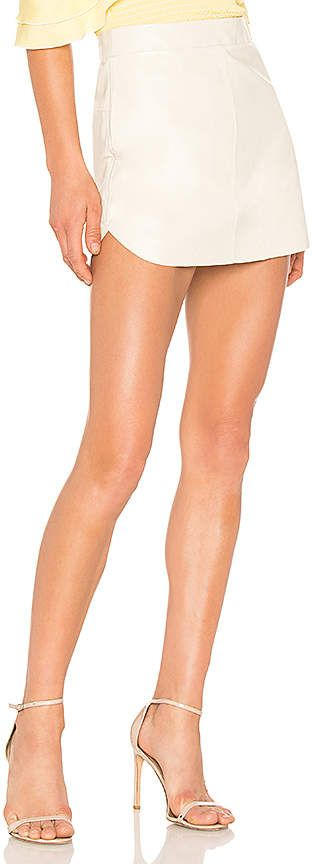



Recommendation for ['e3189352feac272d652e8ef7ac295b6c.jpg']:


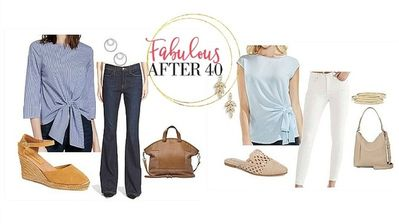

Recommendation:



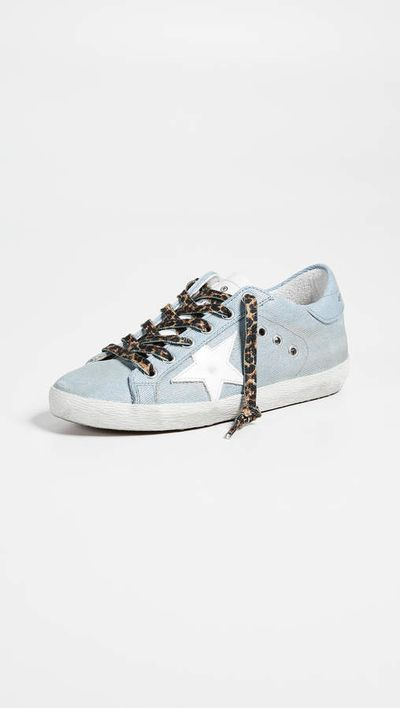



Recommendation:



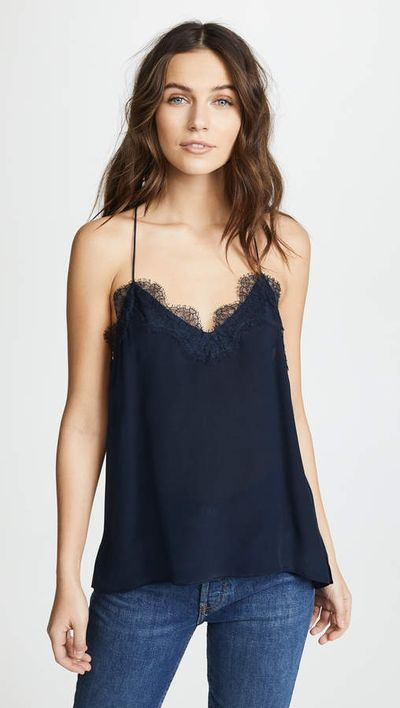



Recommendation for ['19dd842170115b02663c9abea73bcd58.jpg']:


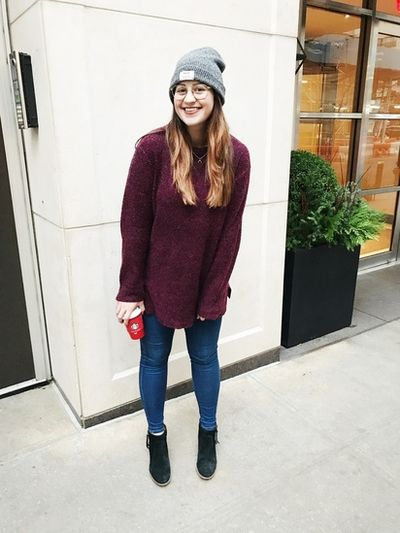

Recommendation:



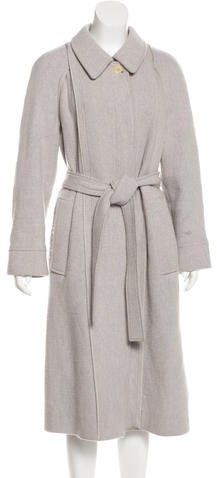



Recommendation for ['02db4aae8eb6a7299926da40586b677c.jpg']:


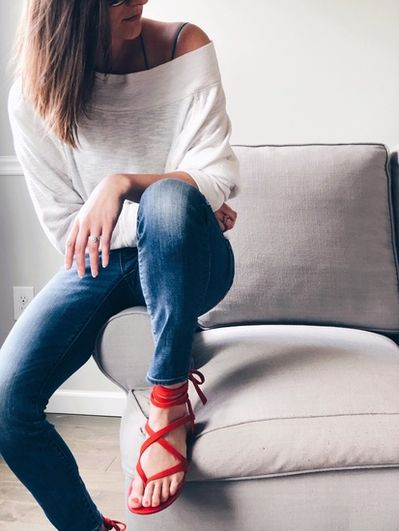

Recommendation:



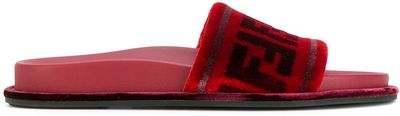



Recommendation:



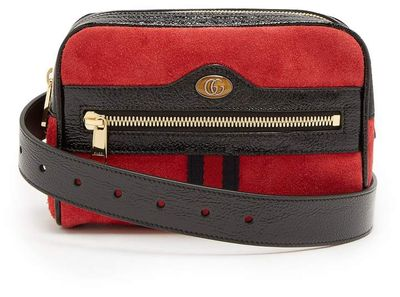



Recommendation:



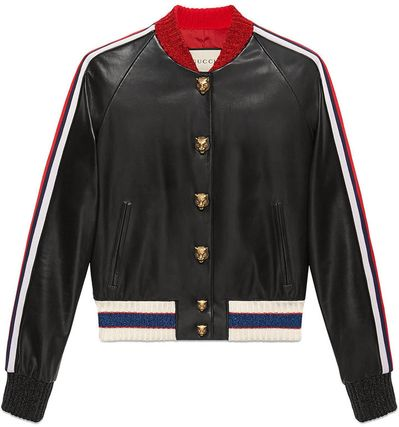



Recommendation:



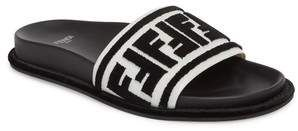



Recommendation:



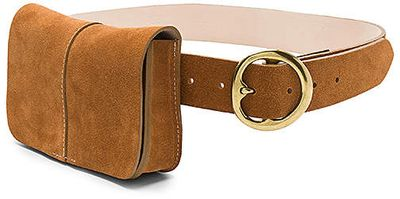



Recommendation:



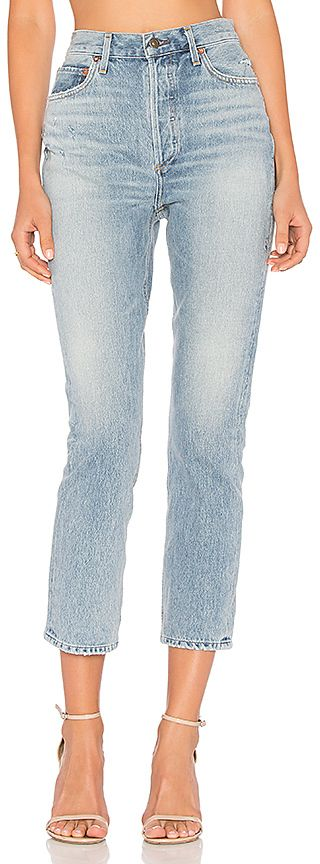



Recommendation:



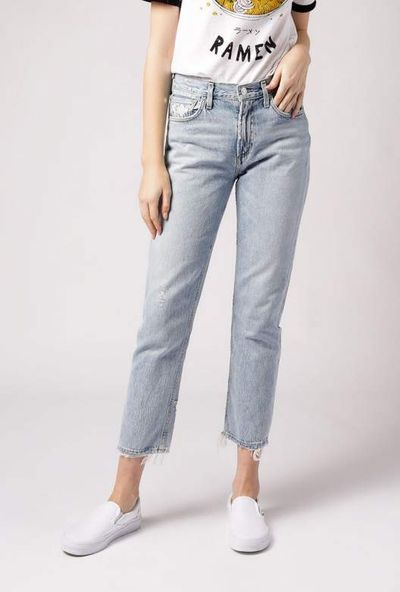



Recommendation:



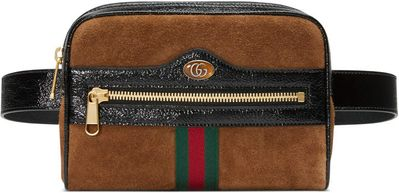



Recommendation:



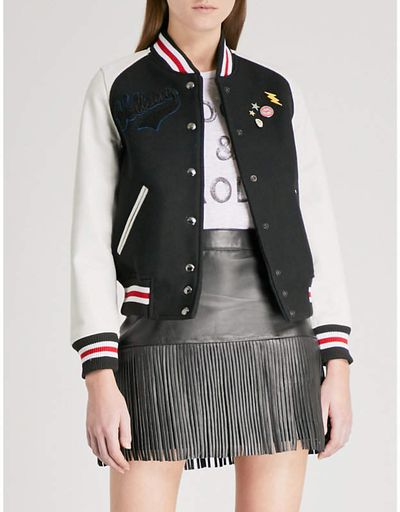



Recommendation:



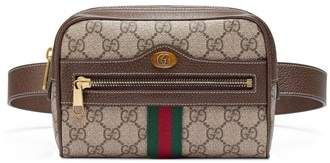



Recommendation:



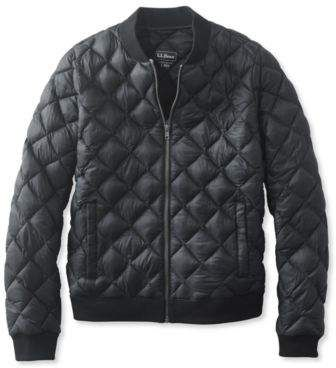



Recommendation:



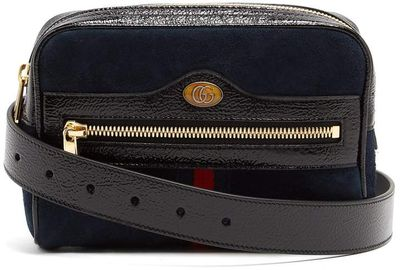



Recommendation:



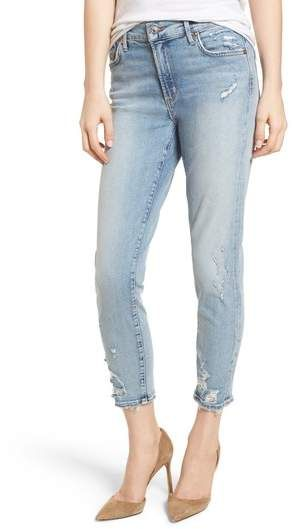



Recommendation:



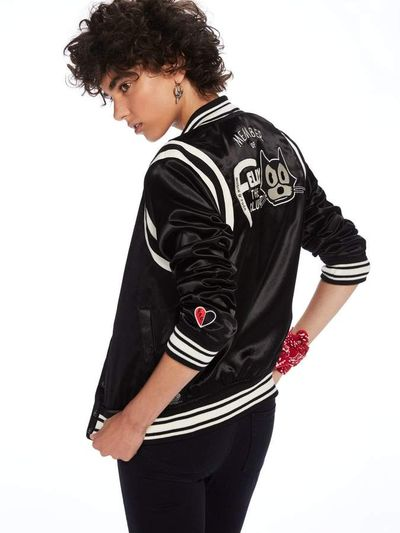



Recommendation:



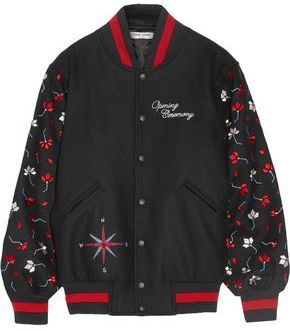



Recommendation:



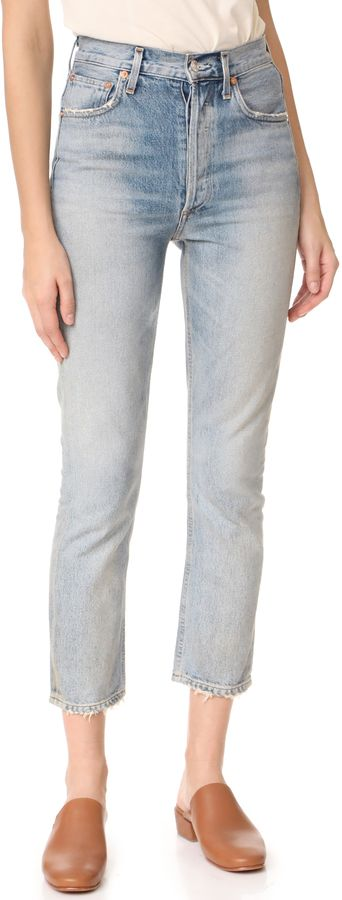

In [ ]:
from IPython.display import Image, display
for img_i in range(len(total_products)):
  print(f'Recommendation for {[full_scenes[img_i][0]]}:')
  display(Image(os.path.join(scene_image_folder,full_scenes[img_i][0])))
  for img_j in total_products[img_i]:
    print("Recommendation:\n")
    display(Image(img_j))
    print("\n")
    